In Diffusion Models, there are three important steps:

1. Adding noise to the images
2. Sampling from the model (starting from noise and getting to an image)
3. Training the model

There are three important statistical variables used in diffusion models (for making the images noisy, and sampling from the diffusion model):
1. $\beta_t \in (0, 1)$; in increasing order with respect to time (in the template code we have set $\beta_1 = 0.0001$ and $\beta_T = 0.02$)
2. $\alpha_t = 1 - \beta_t$
3. $\bar{\alpha}_t = \prod_{s=1}^t \alpha_t$

The noisy image obtained in the timestep $t$ from the original image $X_0$ can be computed as

1. sample from the Gaussian noise $\epsilon \sim \mathcal{N}(0, I)$
2. $X_t \sim \mathcal{N}(X_t; \sqrt{\bar{\alpha}_t}X_0, \sqrt{1 - \bar{\alpha}_t} \epsilon)$

Sampling from the model can be done by the follwing algorithm:

1. sample $X_T$ from the Gaussian noise $\mathcal{N}(0, I)$
2. for $t=T,..., 1$ do:
3. &nbsp;&nbsp;&nbsp;&nbsp;sample a Gaussian noise $\epsilon_t \sim \mathcal{N}(0, I)$
4. &nbsp;&nbsp;&nbsp;&nbsp;$X_{t-1}=\frac{1}{\sqrt{\alpha_t}}(X_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}}\epsilon_\theta(X_t, t)) + \sigma_t \epsilon_t$
5. endfor
6. return $X_0$

In the algorithm above, $\sigma_t = \sqrt{\beta_t}$ or $\sigma_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t}\beta_t$, and all the coefficients (including $\sigma_t$) are preferably computed inside the variance scheduler and accessed as needed. Also, $\epsilon_\theta(X_t, t)$ denotes the noise estimated by the neural network. This neural network is a UNet whose layers admit the time-embeddings as well. In class-conditional diffusion models, the labels are also embedded and combined with the time embedding.

Theoretically, training the model can be done by minimizing the Mean Squared Error between the ground truth noise and the estimated noise as in

$\|\epsilon - \epsilon_\theta(X_t, t)\|^2$

More precisely, training is done based on the following algorithm:

1. for epoch $=1,...,N$ do
2. &nbsp;&nbsp;&nbsp;&nbsp; sample $X_0$ from the data
3. &nbsp;&nbsp;&nbsp;&nbsp; uniformly sample a timestep 1,...,T
4. &nbsp;&nbsp;&nbsp;&nbsp; sample a noise $\epsilon \sim \mathcal{N}(0, I)$
5. &nbsp;&nbsp;&nbsp;&nbsp; take a gradient descent step on the loss function $\|\epsilon - \epsilon_\theta(X_t, t)\|^2$
6. endfor


In [ ]:
# importing the necessary packages
from google.colab import drive
import sys
import torchvision.transforms as transforms

drive.mount('/content/drive/')
dir = "/content/drive/MyDrive/VAEAndDiffusion/"
# ----------------------------------------
sys.path.append(dir)
import os
os.chdir("/content/drive/MyDrive/VAEANdDiffusion/")
# importing the necessary packages
import torch

import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets.mnist import FashionMNIST

# import diffusion model
from diffusion import VarianceScheduler
from diffusion import NoiseEstimatingNet
from diffusion import DiffusionModel
# loading dataset
kwargs = {'root':'FashionMNIST',
          'train':True,
          'transform':transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: 2 * x - 1.)]),
          'download':True}

train_dataset = FashionMNIST(**kwargs)

train_dataset, val_dataset = random_split(train_dataset, [len(train_dataset) - 12000, 12000])

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


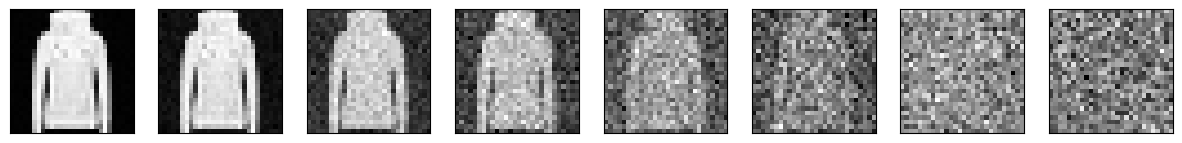

In [ ]:
def train(diffusion_model: DiffusionModel,
          train_loader: DataLoader,
          val_loader: DataLoader,
          optimizer: optim,
          epochs: int,
          device=torch.device('cuda'),
          display_interval: int=5):


  itrs = tqdm(range(epochs))
  itrs.set_description('Train Loss: ? - Val Loss: ?')

  best_loss = float('inf')
  for epoch in itrs:
    avg_train_loss = 0.
    for sample in train_loader:
      x = sample[0].to(device)
      label = sample[1].type(torch.long).to(device)

      optimizer.zero_grad()

      loss = diffusion_model(x, label)

      loss.backward()
      optimizer.step()

      avg_train_loss += loss.item()

    avg_train_loss /= len(train_loader)

    # validating and saving the model
    with torch.no_grad():
      avg_val_loss = 0.
      for sample in val_loader:
        x = sample[0].to(device)
        label = sample[1].type(torch.long).to(device)

        loss = diffusion_model(x, label)

        avg_val_loss += loss.item()

      avg_val_loss /= len(val_loader)

    itrs.set_description(f'Train Loss: {avg_train_loss:.3f} - Val Loss: {avg_val_loss:.3f}')

    # save the model on the best validation loss
    if best_loss > avg_val_loss:
      best_loss = avg_val_loss
      torch.save(diffusion_model.state_dict(), 'diffusion.pt')

    if display_interval is not None:
      if epoch % display_interval == 0 or epoch == epochs - 1:
        # generate some sample to see the quality of the generative model
        samples = diffusion_model.generate_sample(10, torch.arange(10).cuda(), torch.device('cuda'))
        fig, ax = plt.subplots(1, 10)
        fig.set_size_inches(15, 10)
        for i in range(10):
          ax[i].set_xticks([])
          ax[i].set_yticks([])
          ax[i].imshow(samples[i].cpu().permute(1, 2, 0).numpy(), cmap='gray')
        plt.show()
var_schd = VarianceScheduler(num_steps=1000)

sample_image = train_dataset[0][0].unsqueeze(0)

noise_levels = [0, 10, 50, 100, 200, 300, 600, 999]

fig, ax = plt.subplots(1, 8)
fig.set_size_inches(15, 10)
for i in range(8):
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(var_schd.add_noise(sample_image, torch.tensor(noise_levels[i]))[0].squeeze(0).permute(1, 2, 0).numpy(), cmap='gray')
plt.show()


Train Loss: 0.353 - Val Loss: 0.133:   0%|          | 0/50 [00:33<?, ?it/s]

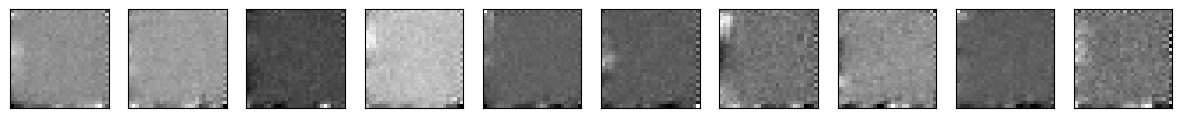

Train Loss: 0.082 - Val Loss: 0.076:   6%|▌         | 3/50 [02:07<24:25, 31.19s/it]

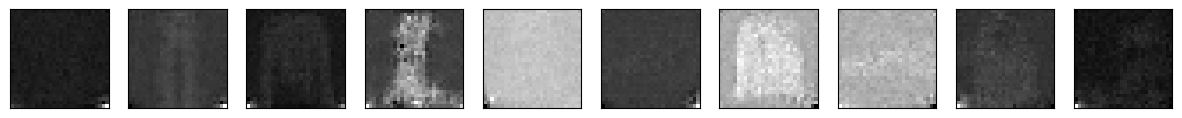

Train Loss: 0.070 - Val Loss: 0.070:  12%|█▏        | 6/50 [03:40<22:28, 30.64s/it]

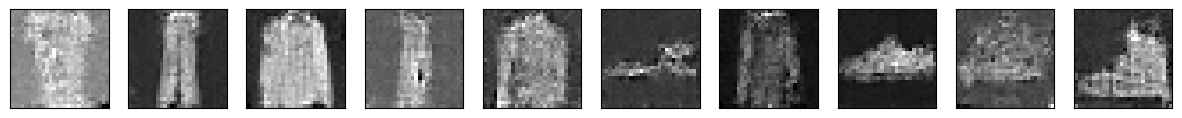

Train Loss: 0.063 - Val Loss: 0.063:  18%|█▊        | 9/50 [05:14<20:46, 30.39s/it]

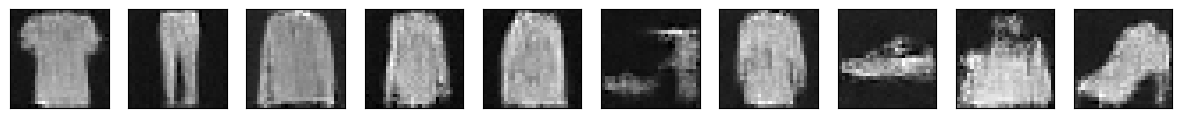

Train Loss: 0.061 - Val Loss: 0.060:  24%|██▍       | 12/50 [06:47<19:06, 30.18s/it]

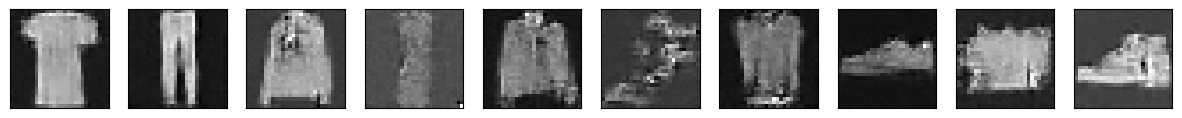

Train Loss: 0.060 - Val Loss: 0.057:  30%|███       | 15/50 [08:24<18:03, 30.96s/it]

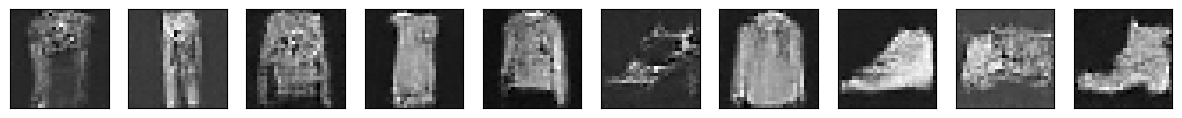

Train Loss: 0.058 - Val Loss: 0.058:  36%|███▌      | 18/50 [10:01<16:44, 31.40s/it]

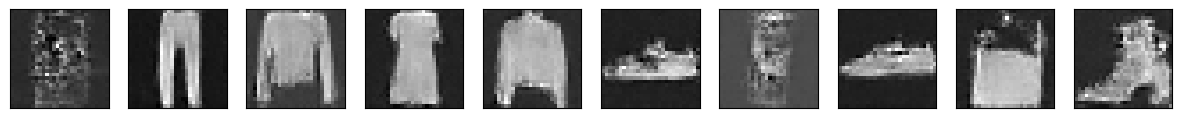

Train Loss: 0.056 - Val Loss: 0.055:  42%|████▏     | 21/50 [11:38<15:09, 31.37s/it]

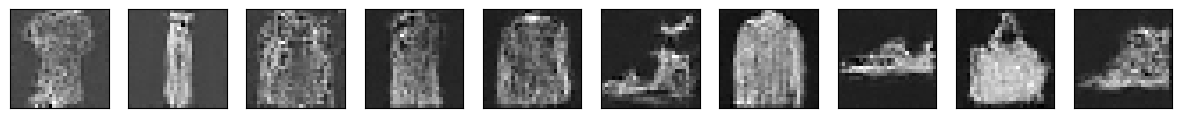

Train Loss: 0.055 - Val Loss: 0.055:  48%|████▊     | 24/50 [13:15<13:43, 31.66s/it]

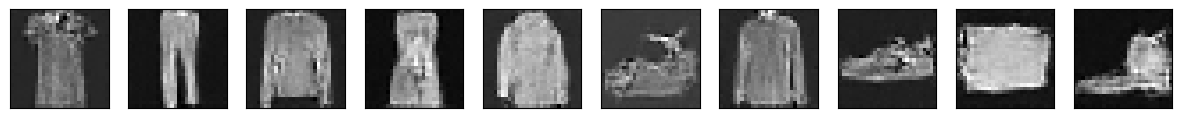

Train Loss: 0.054 - Val Loss: 0.054:  54%|█████▍    | 27/50 [14:52<12:06, 31.59s/it]

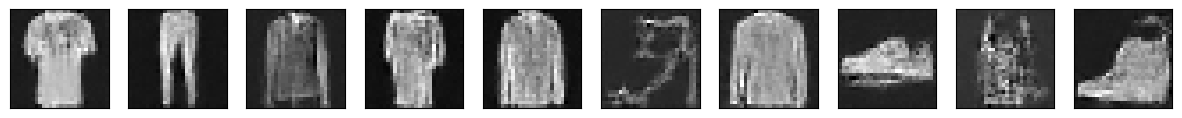

Train Loss: 0.053 - Val Loss: 0.055:  60%|██████    | 30/50 [16:23<10:12, 30.60s/it]

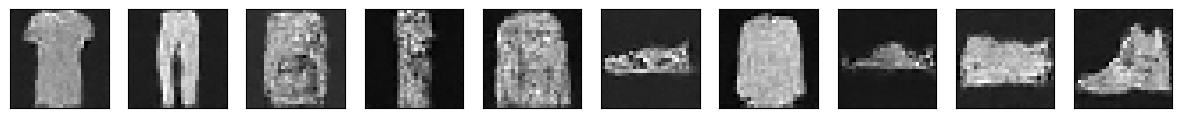

Train Loss: 0.053 - Val Loss: 0.053:  66%|██████▌   | 33/50 [17:54<08:30, 30.02s/it]

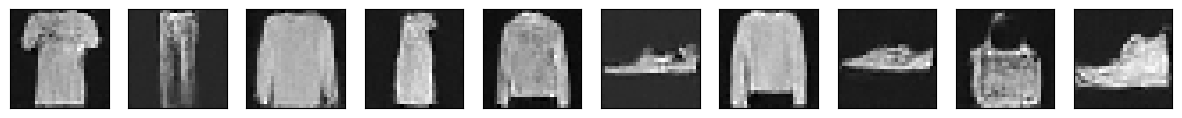

Train Loss: 0.052 - Val Loss: 0.051:  72%|███████▏  | 36/50 [19:26<06:56, 29.73s/it]

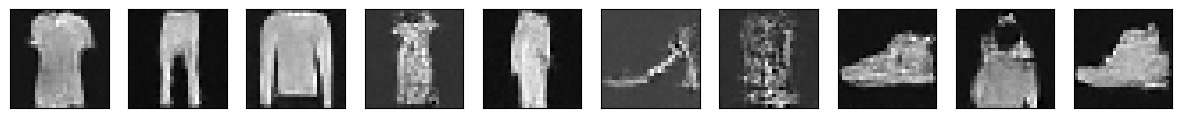

Train Loss: 0.052 - Val Loss: 0.052:  78%|███████▊  | 39/50 [20:58<05:25, 29.59s/it]

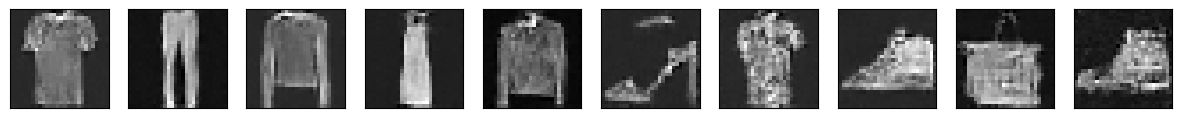

Train Loss: 0.051 - Val Loss: 0.051:  84%|████████▍ | 42/50 [22:29<03:55, 29.49s/it]

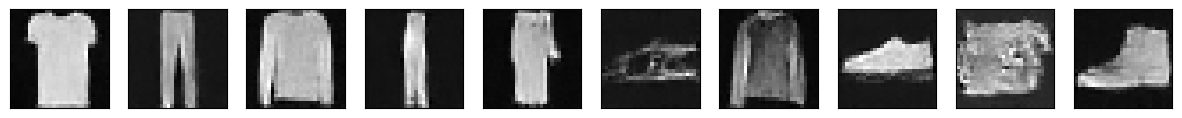

Train Loss: 0.050 - Val Loss: 0.051:  90%|█████████ | 45/50 [24:00<02:28, 29.63s/it]

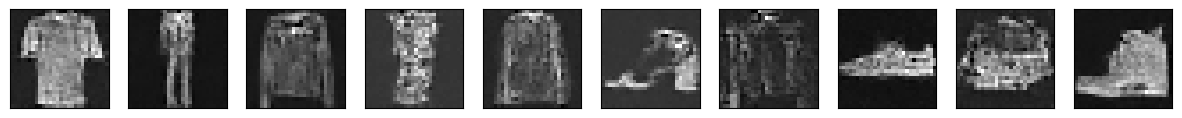

Train Loss: 0.050 - Val Loss: 0.049:  96%|█████████▌| 48/50 [25:31<00:59, 29.61s/it]

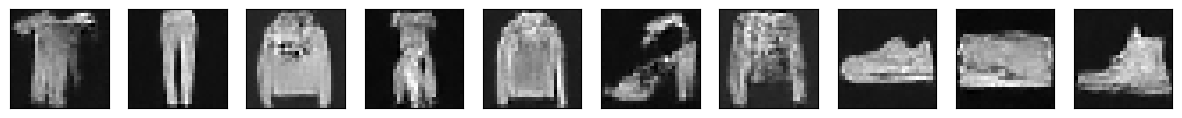

Train Loss: 0.050 - Val Loss: 0.049:  98%|█████████▊| 49/50 [26:06<00:31, 31.21s/it]

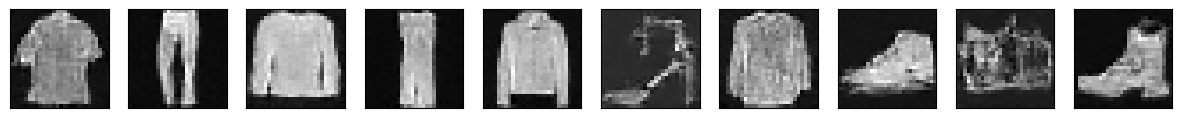

Train Loss: 0.050 - Val Loss: 0.049: 100%|██████████| 50/50 [26:13<00:00, 31.47s/it]


In [ ]:
# training the diffusion model
# setting the configurations
device = torch.device('cuda')
num_steps = 1000
batch_size = 64
lr = 0.0001
epochs = 50
num_classes = 10
display_interval = 3

# defining the diffusion model component nets
var_scheduler = VarianceScheduler(beta_start=0.0001, beta_end=0.02, num_steps=1000)
time_emb_dim = 128
class_emb_dim = 128
num_classes = 10
noise_net = NoiseEstimatingNet(time_emb_dim = time_emb_dim, class_emb_dim = class_emb_dim).to(device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# defining the diffusion model
diffusion = DiffusionModel(noise_net, var_scheduler).to(device)

optimizer = optim.Adam(diffusion.parameters(), lr)

# training the diffusion model
train(diffusion_model=diffusion,
      train_loader=train_loader,
      val_loader=val_loader,
      optimizer=optimizer,
      epochs=epochs,
      device=device,
      display_interval=display_interval)


In [ ]:
# a classifier trained on FashionMNIST
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(in_features=64*7*7, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [ ]:
# here we use the classifier to see if how well it can classify the generated images
# generate 5 samples from each class
desired_labels = []
for i in range(10):
    for _ in range(5):
        desired_labels.append(i)

desired_labels = torch.tensor(desired_labels).to(device)
# load diffusion model
diffusion.load_state_dict(torch.load('diffusion.pt'))
diffusion = diffusion.to(device)



In [ ]:
classifier = Classifier().to(device)
classifier.load_state_dict(torch.load('classifier.pt'))
# generate samples from the Diffusion
len = 100
sum = 0
for i in range(len):
  generated_samples = diffusion.generate_sample(50, desired_labels, device)

  # normalizing the results
  min_per_batch = generated_samples.flatten(start_dim=1).min(dim=-1).values.reshape(-1, 1, 1, 1)
  max_per_batch = generated_samples.flatten(start_dim=1).max(dim=-1).values.reshape(-1, 1, 1, 1)
  generated_samples = (generated_samples - min_per_batch) / (max_per_batch - min_per_batch)
  with torch.no_grad():
      preds = classifier(generated_samples)
  preds = torch.argmax(preds, dim=-1)
  acc = (preds == desired_labels).sum() / 50.
  sum += acc
  print(preds)
  print(f'{acc.cpu().item() * 100:.2f}')
print("Avg acc:", sum/len)

tensor([6, 6, 0, 0, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 4, 8, 3, 4, 3, 3, 3, 4, 4, 4,
        4, 5, 5, 5, 8, 5, 6, 6, 6, 4, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9], device='cuda:0')
82.00
tensor([0, 8, 6, 3, 0, 1, 1, 1, 1, 1, 2, 4, 2, 2, 4, 3, 8, 0, 3, 3, 4, 4, 4, 4,
        3, 5, 5, 5, 5, 5, 6, 2, 6, 6, 6, 7, 7, 7, 8, 7, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9], device='cuda:0')
80.00
tensor([6, 0, 0, 3, 0, 1, 1, 1, 1, 1, 2, 6, 2, 2, 2, 3, 3, 8, 3, 3, 4, 4, 2, 4,
        3, 5, 5, 5, 9, 5, 0, 6, 6, 4, 8, 7, 9, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9], device='cuda:0')
78.00
tensor([6, 0, 0, 2, 6, 1, 1, 1, 3, 1, 2, 6, 2, 2, 6, 3, 3, 3, 3, 3, 3, 6, 4, 6,
        4, 8, 5, 5, 5, 8, 4, 6, 6, 7, 8, 7, 9, 9, 7, 7, 8, 3, 8, 3, 8, 9, 9, 9,
        9, 6], device='cuda:0')
62.00
tensor([0, 6, 6, 3, 0, 1, 1, 1, 1, 1, 6, 2, 6, 2, 6, 8, 3, 3, 6, 3, 4, 4, 3, 2,
        6, 8, 5, 5, 5, 5, 6, 6, 2, 6, 6, 7, 7, 9, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9], device='cuda:0')
72.00
tensor([6,